In [116]:
import pandas as pd
import torch
from sentence_transformers import SentenceTransformer, models
import matplotlib.pyplot as plt

In [117]:
import torch.nn as nn
import torch.optim as optim
from sklearn.manifold import TSNE

In [268]:
all_sf_data = pd.concat([
    pd.read_csv('./archive/sf_aliens.csv').assign(type='aliens'),
    pd.read_csv('./archive/sf_alternate_history.csv').assign(type='history'),
    pd.read_csv('./archive/sf_alternate_universe.csv').assign(type='universe'),
    pd.read_csv('./archive/sf_apocalyptic.csv').assign(type='apocalyptic'),
    pd.read_csv('./archive/sf_cyberpunk.csv').assign(type='cyberpunk'),
    pd.read_csv('./archive/sf_dystopia.csv').assign(type='dystopia'),
    pd.read_csv('./archive/sf_military.csv').assign(type='military'),
    pd.read_csv('./archive/sf_robots.csv').assign(type='robots'),
    pd.read_csv('./archive/sf_space_opera.csv').assign(type='space opera'),
    pd.read_csv('./archive/sf_steampunk.csv').assign(type='steampunk'),
    pd.read_csv('./archive/sf_time_travel.csv').assign(type='time travel')
], ignore_index=True)

In [290]:
all_sf_data = all_sf_data.dropna()

In [291]:
all_sf_data.shape

(12944, 12)

In [293]:
train_data = all_sf_data['Book_Description'].tolist()

In [271]:
train_data = [item for item in train_data if isinstance(item, str)]

In [294]:
model_name = "paraphrase-MiniLM-L6-v2"
#tokenizer = AutoTokenizer.from_pretrained(model_name)
model = SentenceTransformer(model_name)

In [295]:
# tentar com loading do modelo, muito lento

# def generate_embeddings(text):
#     inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
#     outputs = model(**inputs)
#     embeddings = outputs.last_hidden_state.mean(dim=1)
#     return embeddings.detach()

In [297]:
#torch.save(embeddings, 'embeddings.pt')
embeddings = torch.load('embeddings.pt')

C:\Users\joao pedro\AppData\Local\Temp\ipykernel_1068\3973269401.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings = torch.load('embeddings.pt')


In [298]:
embeddings.shape

torch.Size([12944, 384])

In [299]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim1=256, hidden_dim2=128):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

In [300]:
input_dim = embeddings.shape[1]
hidden_dim = 128 

# Inicializar o modelo, otimizador e função de perda
autoencoder = AutoEncoder(input_dim, hidden_dim)
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
criterion = nn.MSELoss()

embeddings_tensor = torch.tensor(embeddings, dtype=torch.float32)

C:\Users\joao pedro\AppData\Local\Temp\ipykernel_1068\927011130.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings_tensor = torch.tensor(embeddings, dtype=torch.float32)


In [301]:
epochs = 40
for epoch in range(epochs):
    optimizer.zero_grad()
    decoded, encoded = autoencoder(embeddings_tensor)
    loss = criterion(decoded, embeddings_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

# Extract the fine-tuned embeddings
tuned_embeddings = encoded.detach().numpy()

Epoch 1/40, Loss: 0.04789505898952484
Epoch 2/40, Loss: 0.046729668974876404
Epoch 3/40, Loss: 0.045626211911439896
Epoch 4/40, Loss: 0.044497523456811905
Epoch 5/40, Loss: 0.04327726364135742
Epoch 6/40, Loss: 0.04191193729639053
Epoch 7/40, Loss: 0.0404135063290596
Epoch 8/40, Loss: 0.038892943412065506
Epoch 9/40, Loss: 0.03758664056658745
Epoch 10/40, Loss: 0.036715298891067505
Epoch 11/40, Loss: 0.036013130098581314
Epoch 12/40, Loss: 0.03512785583734512
Epoch 13/40, Loss: 0.034173816442489624
Epoch 14/40, Loss: 0.03339042514562607
Epoch 15/40, Loss: 0.032865848392248154
Epoch 16/40, Loss: 0.03254125639796257
Epoch 17/40, Loss: 0.03231653571128845
Epoch 18/40, Loss: 0.03212960809469223
Epoch 19/40, Loss: 0.03196666017174721
Epoch 20/40, Loss: 0.0318354070186615
Epoch 21/40, Loss: 0.03173316270112991
Epoch 22/40, Loss: 0.03163467347621918
Epoch 23/40, Loss: 0.03151784464716911
Epoch 24/40, Loss: 0.03138667345046997
Epoch 25/40, Loss: 0.03126097843050957
Epoch 26/40, Loss: 0.0311519

In [302]:
torch.save(tuned_embeddings, 'tuned_embeddings.pt')
tuned_embeddings = torch.load('tuned_embeddings.pt')

C:\Users\joao pedro\AppData\Local\Temp\ipykernel_1068\1235394037.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tuned_embeddings = torch.load('tuned_embeddings.pt')


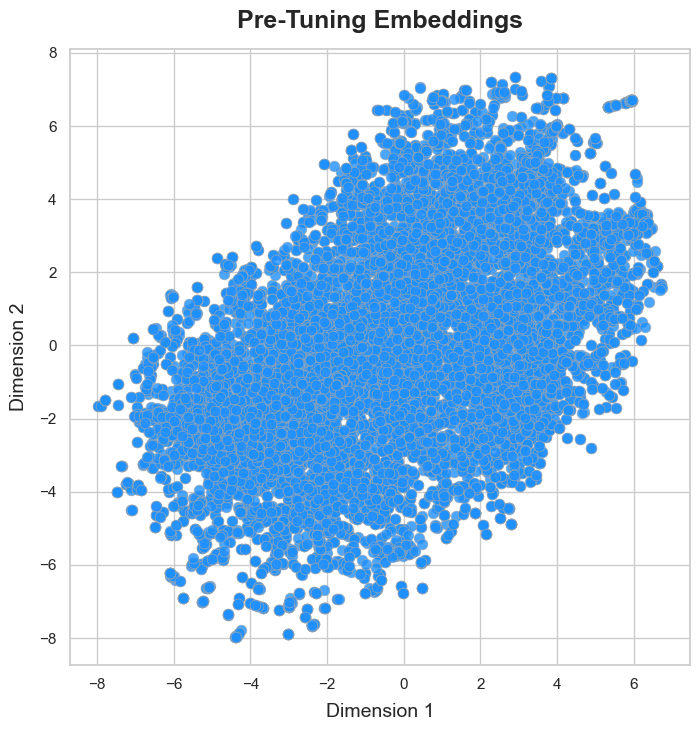

In [360]:
from sklearn.manifold import TSNE
import seaborn as sns

tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
embeddings_2d = tsne.fit_transform(embeddings)

sns.set(style="whitegrid")

plt.figure(figsize=(8, 8))
plt.scatter(
    embeddings_2d[:, 0], embeddings_2d[:, 1], 
    s=60, alpha=0.8, edgecolor="darkgray", linewidth=0.5, c="dodgerblue"
)

plt.title("Pre-Tuning Embeddings", fontsize=18, fontweight="bold", pad=15)
plt.xlabel("Dimension 1", fontsize=14, labelpad=8)
plt.ylabel("Dimension 2", fontsize=14, labelpad=8)

# Optional: Remove grid if preferred for a cleaner look
plt.grid(True)

# Show the plot
plt.show()



c:\Users\joao pedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


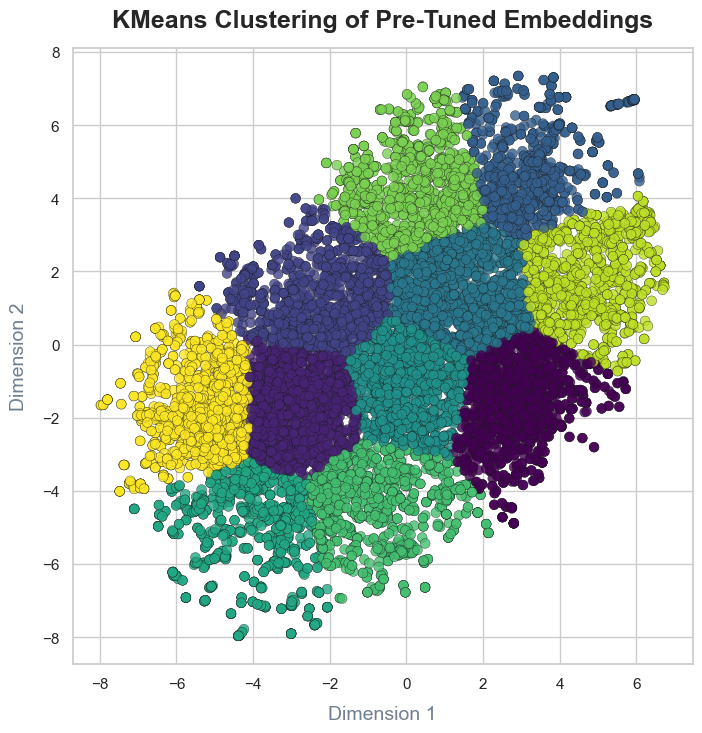

In [362]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=11)
kmeans.fit(embeddings_2d)
y_kmeans = kmeans.predict(embeddings_2d)

sns.set(style="whitegrid")

plt.figure(figsize=(8, 8))
scatter = plt.scatter(
    embeddings_2d[:, 0], embeddings_2d[:, 1], 
    c=y_kmeans, s=50, cmap='viridis', alpha=0.8, edgecolor="k", linewidth=0.3
)

# Customizing title and axis labels
plt.title("KMeans Clustering of Pre-Tuned Embeddings", fontsize=18, fontweight="bold", pad=15)
plt.xlabel("Dimension 1", fontsize=14, color="slategray", labelpad=10)
plt.ylabel("Dimension 2", fontsize=14, color="slategray", labelpad=10)


# Show the plot
plt.show()

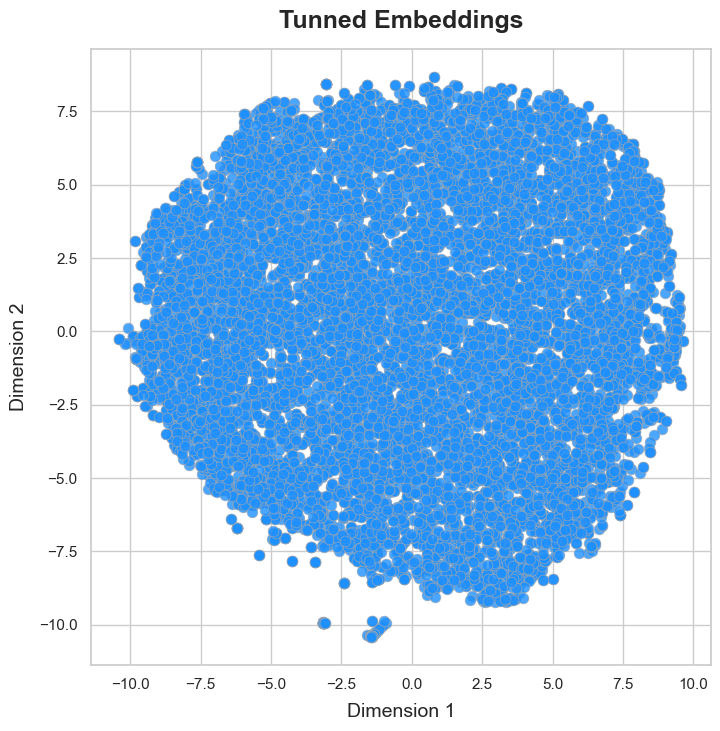

In [363]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
embeddings_2d = tsne.fit_transform(tuned_embeddings)

sns.set(style="whitegrid")

plt.figure(figsize=(8, 8))
plt.scatter(
    embeddings_2d[:, 0], embeddings_2d[:, 1], 
    s=60, alpha=0.8, edgecolor="darkgray", linewidth=0.5, c="dodgerblue"
)

plt.title("Tunned Embeddings", fontsize=18, fontweight="bold", pad=15)
plt.xlabel("Dimension 1", fontsize=14, labelpad=8)
plt.ylabel("Dimension 2", fontsize=14, labelpad=8)

# Optional: Remove grid if preferred for a cleaner look
plt.grid(True)

# Show the plot
plt.show()

c:\Users\joao pedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


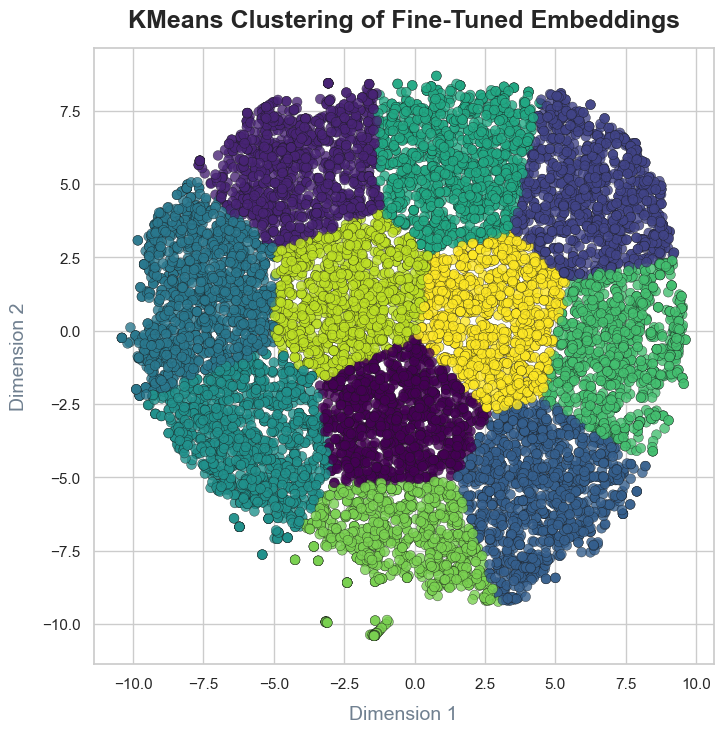

In [364]:
kmeans = KMeans(n_clusters=11)
kmeans.fit(embeddings_2d)
y_kmeans = kmeans.predict(embeddings_2d)

tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
embeddings_2d = tsne.fit_transform(tuned_embeddings)

sns.set(style="whitegrid")

plt.figure(figsize=(8, 8))
scatter = plt.scatter(
    embeddings_2d[:, 0], embeddings_2d[:, 1], 
    c=y_kmeans, s=50, cmap='viridis', alpha=0.8, edgecolor="k", linewidth=0.3
)

# Customizing title and axis labels
plt.title("KMeans Clustering of Fine-Tuned Embeddings", fontsize=18, fontweight="bold", pad=15)
plt.xlabel("Dimension 1", fontsize=14, color="slategray", labelpad=10)
plt.ylabel("Dimension 2", fontsize=14, color="slategray", labelpad=10)


# Show the plot
plt.show()

In [320]:
all_sf_data["cluster"] = y_kmeans

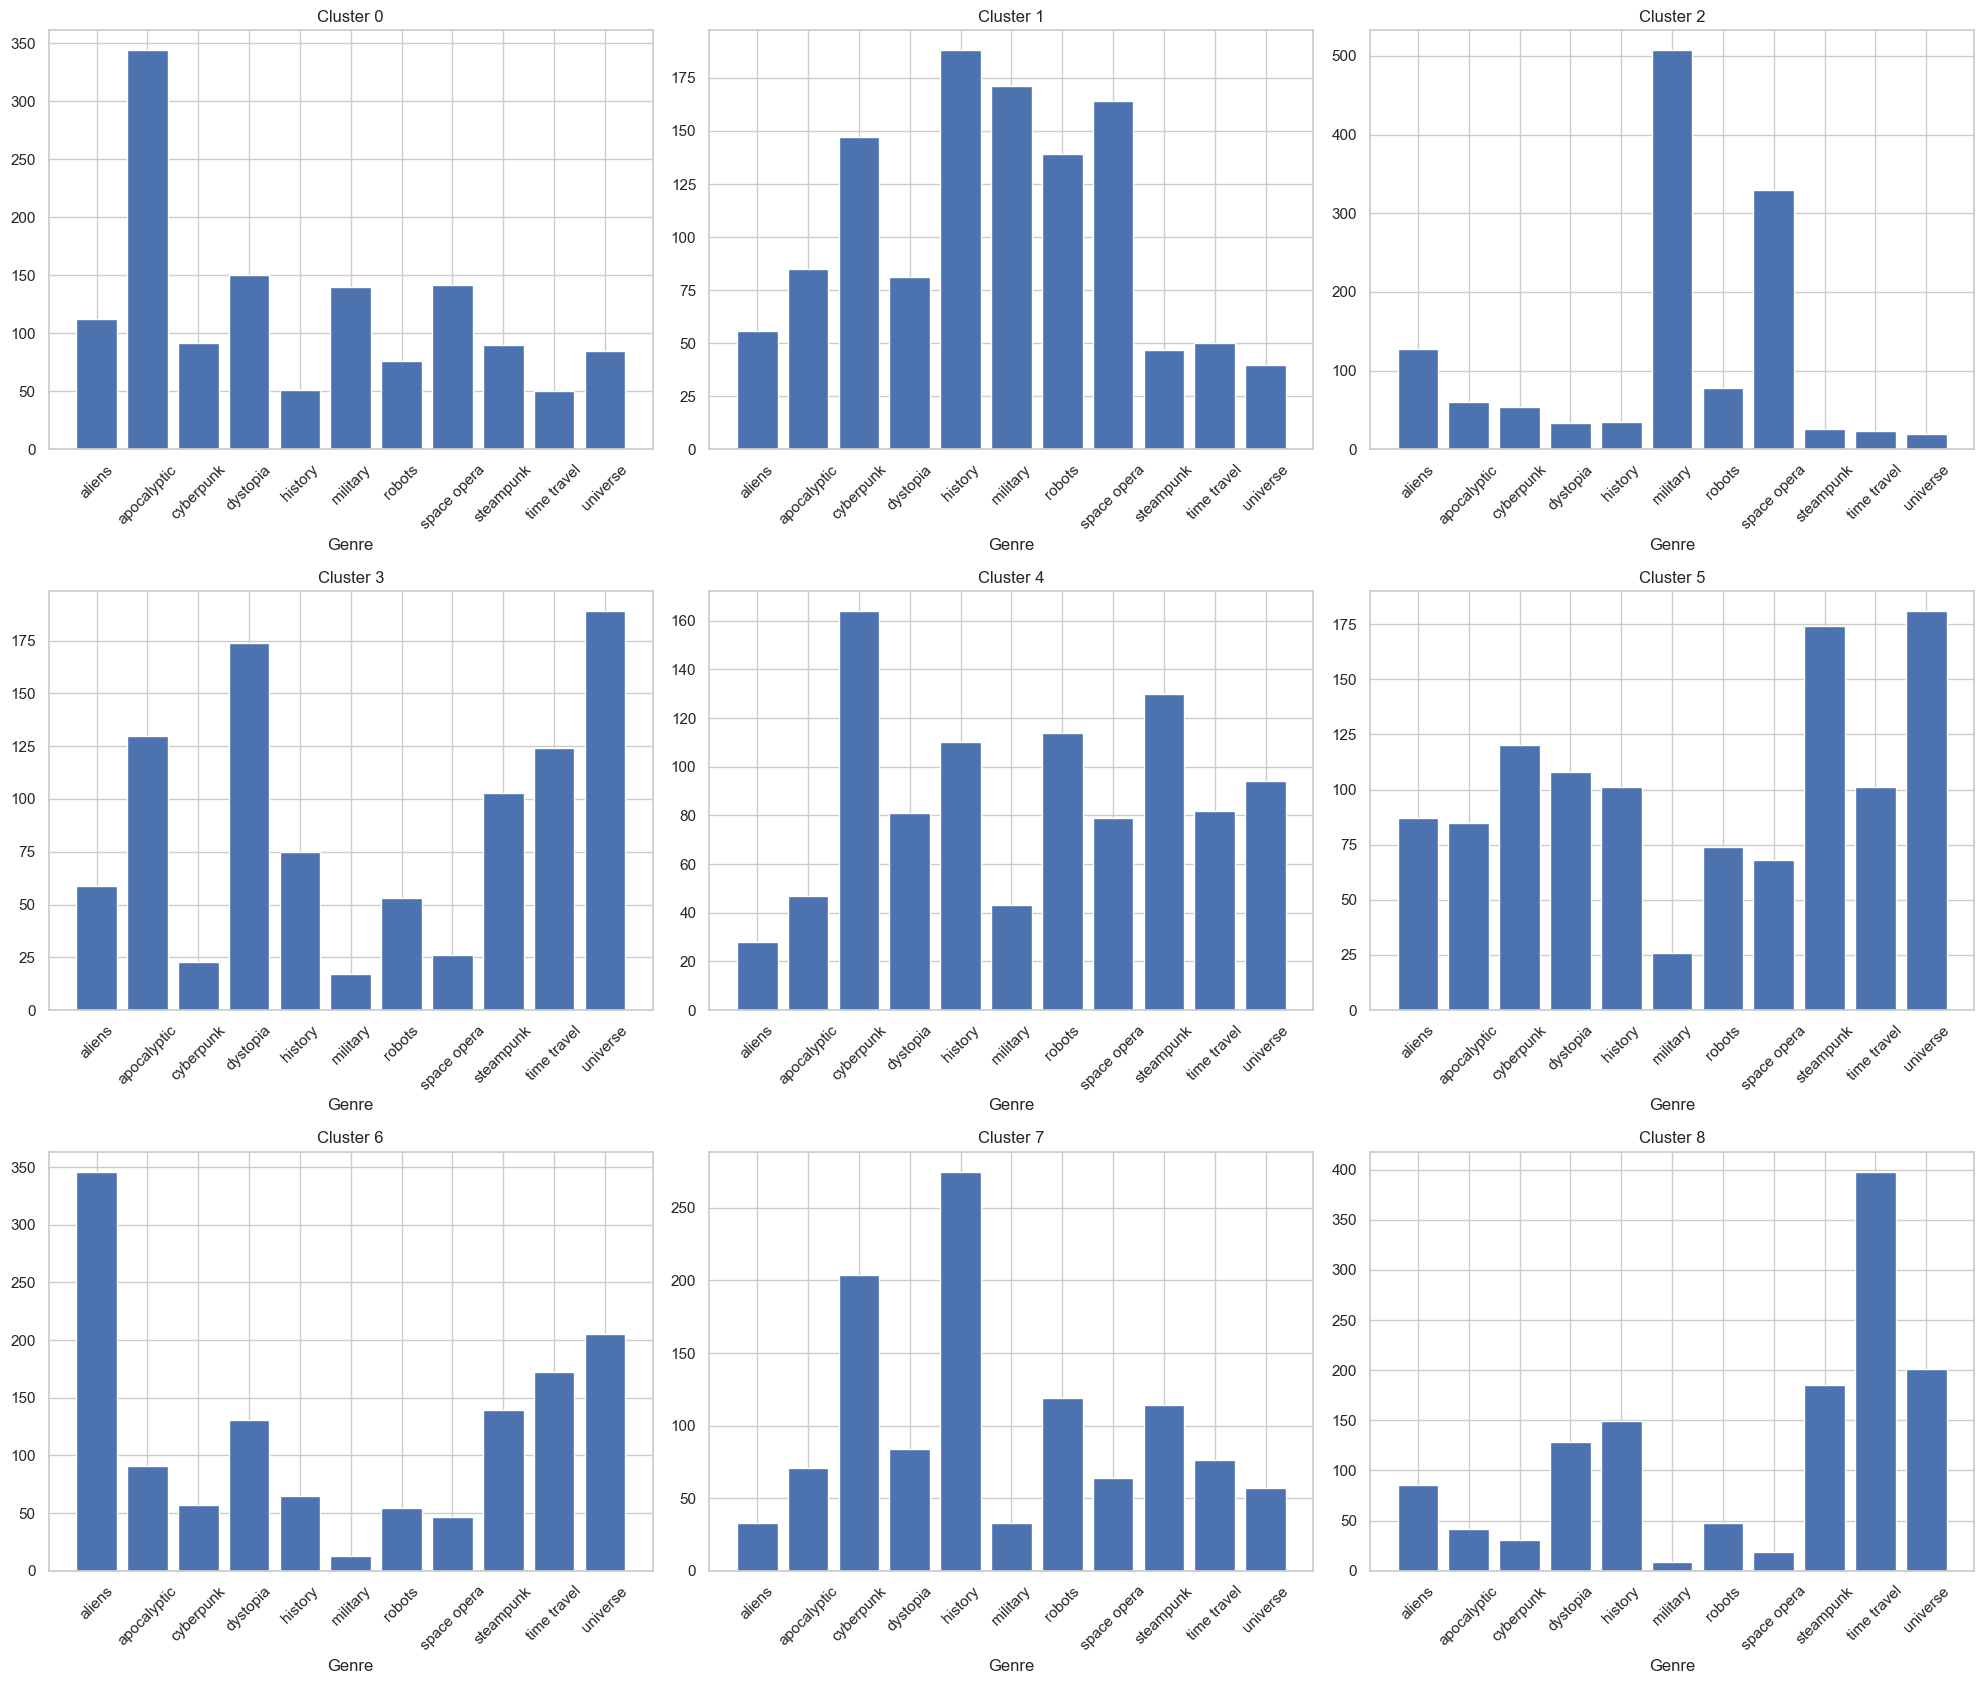

In [359]:
figure, axis = plt.subplots(3, 3, figsize=(20, 17))

for i in range(9):
    axis[i // 3, i % 3].set_title(f"Cluster {i}")
    axis[i // 3, i % 3].set_xlabel("Genre")
    plt.bar(all_sf_data[all_sf_data["cluster"] == i].groupby('type').count()["Book_Title"].index, 
            all_sf_data[all_sf_data["cluster"] == i].groupby('type').count()["Book_Title"])
    plt.subplot(3, 3, i+1)

for ax in axis.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)


plt.tight_layout()
plt.show()

In [478]:
from sklearn.metrics.pairwise import cosine_similarity

def search(query, embeddings, data, threshold=0.9):
    query_embedding = model.encode([query], convert_to_tensor=True)
    _, query_embedding_encoded = autoencoder(query_embedding)
    query_embedding_encoded = query_embedding_encoded.detach().numpy()
    
    similarity_scores = cosine_similarity(query_embedding_encoded, embeddings)[0]
    
    filtered_indices = similarity_scores >= threshold 
    filtered_scores = similarity_scores[filtered_indices]
    sorted_indices = filtered_scores.argsort()[::-1]  
    
    results = data.iloc[filtered_indices].iloc[sorted_indices]
    results['Similarity'] = filtered_scores[sorted_indices]
    
    return results[['Book_Title', 'type', 'Book_Description', 'Similarity']]



In [503]:
query = "book that combines azimov and cathulu"
results = search(query, tuned_embeddings, all_sf_data, threshold=0.93)

grouped_df = results.groupby("Book_Title").agg({
    "type": lambda x: ", ".join(set(x)),
    "Book_Description": "first",
    "Similarity": "max"
}).sort_values('Similarity', ascending=False)

grouped_df

In [504]:
query = "a history about the dangers of AI"
results = search(query, tuned_embeddings, all_sf_data, threshold=0.93)

grouped_df = results.groupby("Book_Title").agg({
    "type": lambda x: ", ".join(set(x)),
    "Book_Description": "first",
    "Similarity": "max"
}).sort_values('Similarity', ascending=False)

grouped_df[:10]

In [505]:
query = "In a galaxy far far away"
results = search(query, tuned_embeddings, all_sf_data, threshold=0.93)

grouped_df = results.groupby("Book_Title").agg({
    "type": lambda x: ", ".join(set(x)),
    "Book_Description": "first",
    "Similarity": "max"
}).sort_values('Similarity', ascending=False)

grouped_df[:10]